In [10]:
import pandas as pd
import numpy as np
import openpyxl
import time

# 파일 경로 설정
sales_file = "sales_transactions.xlsx"  # 실제 파일 경로로 변경하세요

# 처리할 열 지정
use_columns = ["Company", "Date", "TotalPrice"]

# 데이터 타입 지정
dtypes = {"Company": "category", "TotalPrice": "float32"}

# 청크별 결과 저장 리스트
monthly_list = []

# 청크 크기 설정
chunk_size = 10000

# 처리 시간 측정 시작
start_time = time.time()

# 전체 행 수 확인
try:
    print("Excel 파일 행 수 확인 중...")
    wb = openpyxl.load_workbook(sales_file, read_only=True)
    sheet = wb.active
    total_rows = sheet.max_row
    wb.close()
    print(f"총 {total_rows} 행의 데이터가 있습니다.")
except Exception as e:
    print(f"파일 메타데이터 읽기 오류: {e}")
    # 헤더만 읽어서 확인
    header = pd.read_excel(sales_file, nrows=0)
    # 대략적인 행 수 추정
    total_rows = 1000000

# 행 범위 지정하여 여러 번 읽기
for start_row in range(0, total_rows, chunk_size):
    # 현재 청크의 끝 행 계산
    end_row = min(start_row + chunk_size - 1, total_rows)
    
    print(f"처리 중: 행 {start_row+1}~{end_row+1}")
    
    # skiprows 파라미터 설정
    skip_rows = list(range(1, start_row + 1)) if start_row > 0 else None
    
    try:
        # 행 범위를 지정하여 Excel 읽기
        chunk = pd.read_excel(
            sales_file,
            usecols=use_columns,
            dtype=dtypes,
            parse_dates=["Date"],
            skiprows=skip_rows,
            nrows=chunk_size
            # engine="pyarrow" 제거
        )
        
        # 빈 청크면 반복 종료
        if chunk.empty:
            print(f"행 {start_row+1} 이후 데이터가 없습니다. 처리를 종료합니다.")
            break
        
        # 청크 내부에서 월 단위로 그룹화
        chunk["YearMonth"] = chunk["Date"].dt.to_period("M")
        monthly = (chunk
                   .groupby(["Company", "YearMonth"], observed=True)["TotalPrice"]
                   .sum())
        
        # 결과 저장
        monthly_list.append(monthly)
        
        print(f"  - 처리된 행 수: {len(chunk)}")
        
    except Exception as e:
        print(f"청크 처리 중 오류 발생: {e}")
        # observed 파라미터가 지원되지 않는 경우 다시 시도
        try:
            # observed 파라미터 제거하고 재시도
            chunk["YearMonth"] = chunk["Date"].dt.to_period("M")
            monthly = (chunk
                      .groupby(["Company", "YearMonth"])["TotalPrice"]
                      .sum())
            monthly_list.append(monthly)
            print(f"  - 처리된 행 수: {len(chunk)} (observed 파라미터 없이 처리)")
        except Exception as e2:
            print(f"  - 두 번째 시도도 실패: {e2}")
            continue

# 모든 청크의 결과 합치기
if monthly_list:
    print("모든 청크 결과 합치는 중...")
    final_result = pd.concat(monthly_list)
    # 동일한 인덱스별로 합계 계산
    final_result = final_result.groupby(level=[0, 1]).sum()
    
    # 처리 시간 계산
    elapsed_time = time.time() - start_time
    print(f"총 처리 시간: {elapsed_time:.2f}초")
    
    # 결과 출력
    print("\n===== 회사별/월별 판매 합계 =====\n")
    print(final_result.head(10))
else:
    print("처리된 데이터가 없습니다.")

Excel 파일 행 수 확인 중...
총 1501 행의 데이터가 있습니다.
처리 중: 행 1~1502
  - 처리된 행 수: 1500
모든 청크 결과 합치는 중...
총 처리 시간: 0.13초

===== 회사별/월별 판매 합계 =====

Company    YearMonth
AlphaTech  2023-04       44928.00000
           2023-05      610455.06250
           2023-06      516691.71875
           2023-07      544742.00000
           2023-08      540641.06250
           2023-09      252450.18750
           2023-10      411090.15625
           2023-11      555482.62500
           2023-12      668857.00000
           2024-01      641005.31250
Name: TotalPrice, dtype: float32


/var/folders/dm/zsjwvbrs2w55dg2yx48v7rgc0000gn/T/ipykernel_90381/2178896453.py:97: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_result = final_result.groupby(level=[0, 1]).sum()


In [11]:
"""
[예제 2] 판매 기록과 지원 티켓을 회사+날짜 기준으로 결합합니다.
         인덱스 join 방식이 대용량에서 훨씬 빠르고 메모리 효율적입니다.
"""

import pandas as pd

# ───────────────────────── 사용자 프롬프트 ─────────────────────────
sales_file   = input("Sales 파일 (Enter=기본): ")   or "sales_transactions.xlsx"
tickets_file = input("Tickets 파일 (Enter=기본): ") or "support_tickets.xlsx"
# ────────────────────────────────────────────────────────────────

# 1) 원본 로드
sales   = pd.read_excel(sales_file,   parse_dates=["Date"])
tickets = pd.read_excel(tickets_file, parse_dates=["DateOpened", "DateClosed"])

# 2) 조인 키 맞추기 (열 이름을 동일하게)
sales   = sales.rename(columns={"Date": "DateKey"})
tickets = tickets.rename(columns={"DateOpened": "DateKey"})

# 3) 인덱스 설정 후 join
sales_idx   = sales.set_index(["Company", "DateKey"])
tickets_idx = tickets.set_index(["Company", "DateKey"])

merged = sales_idx.join(
    tickets_idx,
    how="inner",      # 필요 시 'left'·'outer'로 변경
    lsuffix="_Sale",
    rsuffix="_Ticket"
).reset_index()

print(f"\n▶︎ 병합 완료! 행 개수: {len(merged):,}")
print(merged[["Company", "DateKey",
              "TransactionID", "TotalPrice",
              "TicketID", "Priority"]].head())



▶︎ 병합 완료! 행 개수: 1,050
     Company    DateKey TransactionID  TotalPrice  TicketID  Priority
0  GammaSoft 2023-07-19      TX-00001    13375.08  TK-00633       Low
1  AlphaTech 2023-10-05      TX-00003    15758.28  TK-00413  Critical
2  AlphaTech 2023-10-05      TX-00003    15758.28  TK-00962    Medium
3  AlphaTech 2025-03-28      TX-00006     5965.00  TK-00034    Medium
4  AlphaTech 2025-03-28      TX-00006     5965.00  TK-00826      High


In [12]:
"""
[예제 3] 고객지원 티켓의 처리 기간(일)을 계산하고,
         SLA 임계값을 넘긴 건만 골라냅니다.
"""

import pandas as pd

tickets_file = input("Tickets 파일 (Enter=기본): ") or "support_tickets.xlsx"
threshold = int(input("SLA 임계값(일, 기본 30): ") or "30")

tickets = pd.read_excel(tickets_file,
                        parse_dates=["DateOpened", "DateClosed"])

tickets["DaysOpen"] = (tickets["DateClosed"] - tickets["DateOpened"]).dt.days
sla_over = tickets.query("DaysOpen > @threshold")

print(f"\n▶︎ SLA {threshold}일 초과 건수: {len(sla_over):,}")
print(sla_over[["TicketID", "Company", "Priority", "DaysOpen"]].head())



▶︎ SLA 30일 초과 건수: 749
    TicketID    Company  Priority  DaysOpen
0   TK-00001  BetaLogix  Critical        47
7   TK-00008  GammaSoft      High        32
10  TK-00011  BetaLogix       Low        42
12  TK-00013  GammaSoft  Critical        44
13  TK-00014  BetaLogix      High        37



▶︎ Top-5 지역 매출
Region
Daejeon    5645847.25
Busan      5977136.62
Incheon    6456771.87
Gwangju    7193601.60
Daegu      7898483.46
Name: TotalPrice, dtype: float64


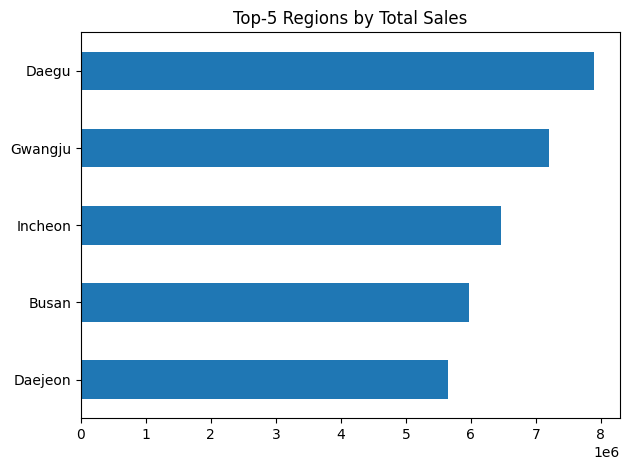

In [13]:
"""
[예제 4] 지역별 총매출 상위 N개를 바차트로 시각화합니다.
         실전에서는 groupby → 작은 DataFrame 으로 차트 생성이 안전합니다.
"""

import pandas as pd
import matplotlib.pyplot as plt

sales_file = input("Sales 파일 (Enter=기본): ") or "sales_transactions.xlsx"
N = int(input("Top N 지역 (기본 5): ") or "5")

sales = pd.read_excel(sales_file, usecols=["Region", "TotalPrice"])
topN = (sales.groupby("Region")["TotalPrice"]
              .sum()
              .nlargest(N)
              .sort_values())

print("\n▶︎ Top-{} 지역 매출".format(N))
print(topN)

topN.plot(kind="barh",
          title=f"Top-{N} Regions by Total Sales",
          ylabel="")
plt.tight_layout()
plt.show()


In [14]:
"""
[예제 5] Software 매출 대비 'Critical' 우선순위 지원 티켓 비율을 구하고,
         위험도가 높은 회사를 추출합니다.
"""

import pandas as pd

sales_file   = input("Sales 파일 (Enter=기본): ")   or "sales_transactions.xlsx"
tickets_file = input("Tickets 파일 (Enter=기본): ") or "support_tickets.xlsx"

sales   = pd.read_excel(sales_file)
tickets = pd.read_excel(tickets_file)

# ── (1) Software 매출 집계 ───────────────────────────────
sw_sales = sales[sales["ProductCategory"] == "Software"]
tot_sales = sw_sales.groupby("Company")["TotalPrice"].sum()

# ── (2) Critical 티켓 건수 ──────────────────────────────
crit_cnt = (tickets[tickets["Priority"] == "Critical"]
            .groupby("Company")["TicketID"]
            .count())

# ── (3) 매출 대비 Critical 건 비율 산출 ────────────────
risk_df = pd.concat([tot_sales, crit_cnt], axis=1, keys=["SW_Sales", "CriticalCnt"]) \
             .fillna(0)

# 매출 10만 달러당 Critical 건수 (지표 예시)
risk_df["CriticalRate_per_100k"] = risk_df["CriticalCnt"] / \
                                   (risk_df["SW_Sales"] / 100_000)

# ── (4) 위험도 필터링 ──────────────────────────────────
limit = float(input("위험도 임계값(건/10만$, 기본 3): ") or "3")
high_risk = risk_df.query("CriticalRate_per_100k > @limit")

print(f"\n▶︎ 위험도 {limit} 이상 회사 목록")
print(high_risk.sort_values("CriticalRate_per_100k", ascending=False))



▶︎ 위험도 3.0 이상 회사 목록
             SW_Sales  CriticalCnt  CriticalRate_per_100k
Company                                                  
BetaLogix  4307115.54          151               3.505827
AlphaTech  3856278.48          116               3.008082
